In [429]:
import pandas as pd
import nltk as nk
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.stem import SnowballStemmer

%matplotlib inline

In [106]:
tickets = pd.read_excel('tickets.xlsx')

In [107]:
tickets.head()

,ticket_number,asunto,cliente,pais,tecnico_asignado,descripcion,estado,fecha_Creacion,label
0,10227,Firmware Zkt Eco MB 300,ENOC,Mexico,Eduardo,Podrían mandarme el firmware para el reloj che...,En proceso,2018-01-16 01:26:27.0,request
1,10232,ZKACCESS 3.5,DIEGO,Ecuador,Eduardo,INSTALE EL SOFTWARE EN WINDOWS 10 Y AL TRABAJA...,Sin procesar,2018-01-16 04:58:41.0,incident
2,10229,ZKT ECO LX14,CARLA,Peru,wmagallanes,"RELOJ HUELLA ZKT ECO LX14, SOLICITAMOS REINSTA...",En proceso,2018-01-16 01:47:16.0,request
3,10221,Problema al importar empleados de excel,roger,Peru,Williampe,Muy buenos días... tengo 122 usuarios agregado...,En proceso,2018-01-15 22:47:17.0,incident
4,10231,gestion de uhf a travez del inbio,franco,Mexico,omendoza,"buen dia, hemos instalado en proyectos para a...",Sin procesar,2018-01-16 03:08:50.0,incident


In [54]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 9 columns):
ticket_number       143 non-null int64
asunto              143 non-null object
cliente             143 non-null object
pais                143 non-null object
tecnico_asignado    143 non-null object
descripcion         143 non-null object
estado              143 non-null object
fecha_Creacion      143 non-null object
label               143 non-null object
dtypes: int64(1), object(8)
memory usage: 10.1+ KB


In [108]:
tickets['descripcion'] = tickets['descripcion'].apply(lambda d : d.lower())

In [109]:
#Remove duplicated rows
tickets.drop_duplicates(subset='descripcion', keep='first', inplace=True)

In [110]:
tickets['label'].unique()

array(['request', 'incident', 'customization'], dtype=object)

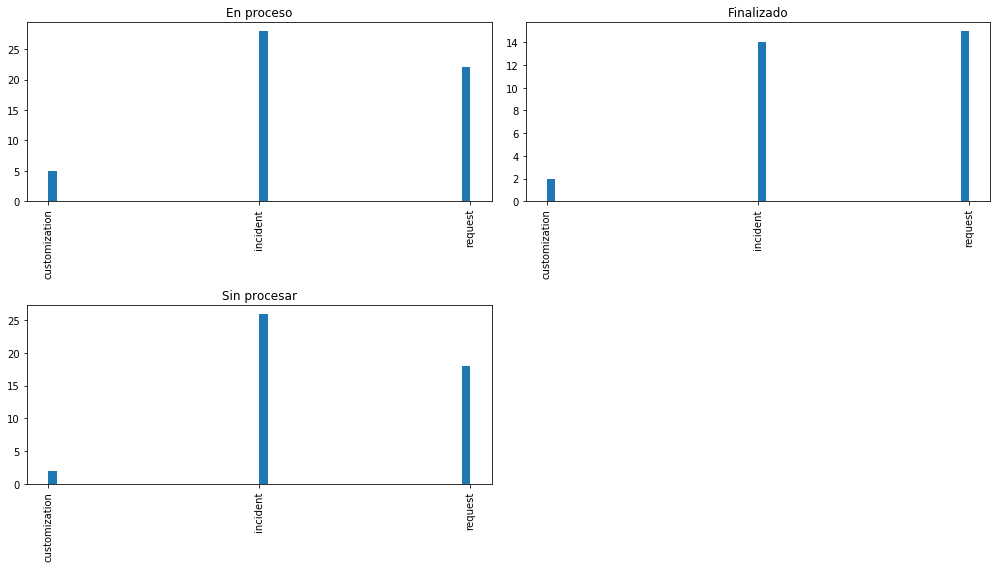

In [111]:
tickets.hist(column='label', by='estado', figsize=(14, 8), bins=50)
plt.tight_layout()

In [112]:
def removePunctuation(sentence):
    r = [char for char in sentence if char not in string.punctuation]
    return ''.join(r)

In [113]:
def removeStopWords(sentence):
    return [word for word in sentence.split() if word.lower() not in stopwords.words('spanish')]

#look for similar words...

In [146]:
def cleanText(s):
    return removeStopWords(removePunctuation(s))

In [115]:
def stem_tokens(tokens):
    stemmer = SnowballStemmer('spanish')
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [166]:
def cleanTextWithStemTokens(s):
    return stem_tokens(cleanText(s))

In [197]:
print(cleanText(tickets['descripcion'][0]))
print('\n')
print(cleanTextWithStemTokens(tickets['descripcion'][0]))

['podrían', 'mandarme', 'firmware', 'reloj', 'checador', 'mb300']


['podr', 'mand', 'firmwar', 'reloj', 'checador', 'mb300']


In [309]:
trainset = tickets
X_train, X_test, y_train, y_test = train_test_split(trainset['descripcion'], trainset['label'], test_size=0.35, random_state=42)

In [460]:
predict_pipeline = Pipeline([
    ('BOW', CountVectorizer(analyzer=cleanText)),
    ('Tifid', TfidfTransformer()),
    ('Clasifier', MultinomialNB())
                            ])

#predict_pipeline = Pipeline([
#    ('BOW', CountVectorizer(analyzer=cleanTextWithStemTokens)),
#    ('Tifid', TfidfTransformer()),
#    ('Clasifier', SGDClassifier(loss='hinge', max_iter=1000, random_state=42))
#                            ])

#SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)

In [436]:
predict_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('BOW', CountVectorizer(analyzer=<function removePunctuation at 0x1a2570c9d8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...tf=False, use_idf=True)), ('Clasifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [437]:
trainset['label'].iloc[5]

'incident'

In [438]:
predict_pipeline.predict([trainset['descripcion'].iloc[5]])

array(['incident'],
      dtype='<U13')

In [439]:
predictions = predict_pipeline.predict(X_test)

In [440]:
print(classification_report(predictions, y_test))
print('\n')
print(confusion_matrix(predictions, y_test))

               precision    recall  f1-score   support

customization       0.00      0.00      0.00         0
     incident       1.00      0.50      0.67        46
      request       0.05      1.00      0.09         1

  avg / total       0.98      0.51      0.65        47



[[ 0  0  0]
 [ 3 23 20]
 [ 0  0  1]]


/Users/matiasgonzalez/anaconda2/envs/python3DevelopmentPythonCourse/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [124]:
tickets.groupby(by='label')['label'].count()

label
customization     9
incident         68
request          55
Name: label, dtype: int64

In [125]:
from sklearn.grid_search import GridSearchCV

In [314]:
predict_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'BOW', 'Tifid', 'Clasifier', 'BOW__analyzer', 'BOW__binary', 'BOW__decode_error', 'BOW__dtype', 'BOW__encoding', 'BOW__input', 'BOW__lowercase', 'BOW__max_df', 'BOW__max_features', 'BOW__min_df', 'BOW__ngram_range', 'BOW__preprocessor', 'BOW__stop_words', 'BOW__strip_accents', 'BOW__token_pattern', 'BOW__tokenizer', 'BOW__vocabulary', 'Tifid__norm', 'Tifid__smooth_idf', 'Tifid__sublinear_tf', 'Tifid__use_idf', 'Clasifier__alpha', 'Clasifier__class_prior', 'Clasifier__fit_prior'])

In [454]:
#SGV
#params = {'Tifid__use_idf':(True, False),
#         'Clasifier__penalty':('none', 'l2', 'l1', 'elasticnet'),
#         'Clasifier__alpha': (1e-2, 1e-5),
#         'BOW__ngram_range': [(1, 1), (1, 2)]}

#MULTINOMIAL NB
params = {'Tifid__use_idf':(True, False),
         'Clasifier__alpha': (1e-2, 1e-10),
         'BOW__ngram_range': [(1, 1), (1, 2)]}

#'vect__ngram_range': [(1, 1), (1, 2)],
#...               'tfidf__use_idf': (True, False),
#...               'clf__alpha': (1e-2, 1e-3)

In [461]:
grid_test = GridSearchCV(predict_pipeline, params, verbose=3, n_jobs=-1)

In [462]:
grid_test.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=True 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=True 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=True 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=False 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=False 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=False 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=1e-10, Tifid__use_idf=True 
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=1e-10, Tifid__use_idf=True 
[CV]  BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=True, score=0.642857 -   0.9s
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=1e-10, Tifid__use_idf=True 
[CV]  BOW__ngram_range=(1, 1), Clasifier__alpha=0.01, Tifid__use_idf=True, score=0.620690 -   1.0s
[CV] BOW__ngram_range=(1, 1), Clasifier__alpha=1e-10, Tifid__use_idf=F

[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    3.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('BOW', CountVectorizer(analyzer=<function cleanText at 0x1a259b6598>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
 ...tf=False, use_idf=True)), ('Clasifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'Tifid__use_idf': (True, False), 'Clasifier__alpha': (0.01, 1e-10), 'BOW__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [466]:
import json

json.dumps(grid_test.best_params_)

'{"BOW__ngram_range": [1, 1], "Clasifier__alpha": 0.01, "Tifid__use_idf": true}'

In [464]:
grid_predictions = grid_test.predict(X_test)

In [465]:
print(classification_report(grid_predictions, y_test))
print('\n')
print(confusion_matrix(grid_predictions, y_test))

               precision    recall  f1-score   support

customization       0.00      0.00      0.00         1
     incident       0.91      0.75      0.82        28
      request       0.71      0.83      0.77        18

  avg / total       0.82      0.77      0.79        47



[[ 0  0  1]
 [ 2 21  5]
 [ 1  2 15]]


In [430]:
type(grid_test.predict(['software deshabilitado,tengo el software deshabilitado']))

numpy.ndarray

In [413]:
grid_test.predict(['Buenos días, un cliente tiene un E9-C el cual queda colgado en la pantalla de bienvenida. Pero aun tiene conexión desde el software. Es posible recargar el firmware desde alli? De ser asi me podran enviar el archivo. Desde ya muchas gracias.Saludos'])

array(['incident'],
      dtype='<U13')

In [434]:
grid_test.predict(['Buenos dias, podrian enviarme un manual del SA33-E']).tolist()[0]+'\n'

'request\n'

In [415]:
grid_test.predict(['Hola, para un desarrollo en Argentina necesito lector de huella digital USB con SDK para windows 10 Iot qu eme permita comparar huellas con una base personal existente. Me pueden ayudar? saludos, Fernando López'])

array(['incident'],
      dtype='<U13')

In [416]:
grid_test.predict(['procedimiento completo para pasar una base de datos con todos los parametros biometricos de servidor zktime web 2.0 de un servidor a otro, y que quede operativa'])

array(['request'],
      dtype='<U13')

In [398]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=3, random_state=42, max_iter=10000)

In [399]:
find_groups_pipeline = Pipeline([
    ('BOW', CountVectorizer(analyzer=cleanTextWithStemTokens)),
    ('Tifid', TfidfTransformer()),
    ('Clasifier', kmean)
                            ])

In [400]:
find_groups_pipeline.fit(tickets['descripcion'])

Pipeline(memory=None,
     steps=[('BOW', CountVectorizer(analyzer=<function cleanTextWithStemTokens at 0x1a2533d620>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepro...s=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])

In [401]:
kmean.cluster_centers_

array([[ 0.00218021,  0.01205388,  0.0020156 , ...,  0.00962297,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00267376,  0.00275358]])

In [402]:
kmean.labels_

array([0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 2,
       1, 2, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 1, 2, 0, 0, 1, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 0, 2, 0,
       2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2], dtype=int32)

In [364]:
def getLabels(array):
    labelArray=[]
    for a in array:
        if a==0:
            labelArray.append('request')
        if a==1:
            labelArray.append('incident')
        if a==2:
            labelArray.append('customization')
    return labelArray

In [403]:
print(classification_report(tickets['label'], getLabels(kmean.labels_)))
print('\n')
print(confusion_matrix(tickets['label'], getLabels(kmean.labels_)))

               precision    recall  f1-score   support

customization       0.10      0.89      0.18         9
     incident       0.57      0.19      0.29        68
      request       0.20      0.11      0.14        55

  avg / total       0.38      0.20      0.22       132



[[ 8  1  0]
 [31 13 24]
 [40  9  6]]


In [404]:
tickets['kmean'] = getLabels(kmean.labels_)

In [391]:
tickets

,ticket_number,asunto,cliente,pais,tecnico_asignado,descripcion,estado,fecha_Creacion,label,kmean
0,10227,Firmware Zkt Eco MB 300,ENOC,Mexico,Eduardo,podrían mandarme el firmware para el reloj che...,En proceso,2018-01-16 01:26:27.0,request,request
1,10232,ZKACCESS 3.5,DIEGO,Ecuador,Eduardo,instale el software en windows 10 y al trabaja...,Sin procesar,2018-01-16 04:58:41.0,incident,request
2,10229,ZKT ECO LX14,CARLA,Peru,wmagallanes,"reloj huella zkt eco lx14, solicitamos reinsta...",En proceso,2018-01-16 01:47:16.0,request,incident
3,10221,Problema al importar empleados de excel,roger,Peru,Williampe,muy buenos días... tengo 122 usuarios agregado...,En proceso,2018-01-15 22:47:17.0,incident,customization
4,10231,gestion de uhf a travez del inbio,franco,Mexico,omendoza,"buen dia, hemos instalado en proyectos para a...",Sin procesar,2018-01-16 03:08:50.0,incident,incident
5,10187,sale error de registro,edgar,Peru,Williampe,buenas estimado sale error al momento que regi...,En proceso,2018-01-12 05:56:36.0,incident,request
6,10191,actualización Firmware,jhon jairo,Colombia,Marioag,tengo el equipo zteco in01a y no me aparece la...,En proceso,2018-01-12 16:17:10.0,incident,incident
7,10186,reporte,gerardo uriel,Mexico,Eduardo,buenos dias \nnosotros manejajos varios reloj...,En proceso,2018-01-12 04:58:03.0,customization,incident
8,10230,Manual y Software,Carlos,Mexico,Jcastruita,compramos este equipo silkbio-100tcid y no tra...,Sin procesar,2018-01-16 02:35:08.0,incident,request
9,10205,Solicitud de Manual de Usuario,Alejandra,Mexico,Eduardo,solicito su apoyo para la obtención del manual...,En proceso,2018-01-13 03:00:28.0,request,customization
